<a href="https://colab.research.google.com/github/anjaliharidevan-glitch/Internship/blob/main/Amazon_food_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who voted whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br>
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
!pip install nltk

In [5]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 54.2 MB/s eta 0:00:00


In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [7]:
import pandas as pd

# Load the data from the CSV file, specifying quote character and handling double quotes
filtered_data = pd.read_csv('/content/Reviews.csv', quotechar='"', doublequote=True, on_bad_lines='skip', engine='python')

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0  # Negative
    return 1  # Positive

# Exclude reviews with a score of 3
filtered_data = filtered_data[filtered_data['Score'] != 3].copy()

# Apply the partition function to the 'Score' column
filtered_data['Score'] = filtered_data['Score'].map(partition)

print("Number of data points after excluding score 3:", filtered_data.shape)
display(filtered_data.head(3))

Number of data points after excluding score 3: (23491, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
# Query the filtered_data DataFrame using pandas
display = filtered_data.groupby('UserId').filter(lambda x: len(x) > 1)
display = display[['UserId', 'ProductId', 'ProfileName', 'Time', 'Score', 'Text']].copy()
display['COUNT(*)'] = display.groupby('UserId')['UserId'].transform('count')

print("Number of data points with more than one review per user:", display.shape)
display.head()

Number of data points with more than one review per user: (4897, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
10,A3HDKO7OW0QNK4,B0001PB9FE,Canadian Fan,1107820800,1,I don't know if it's the cactus or the tequila...,2
11,A2725IB4YY9JEB,B0009XLVG0,"A Poeng ""SparkyGoHome""",1282867200,1,One of my boys needed to lose some weight and ...,2
14,A2MUGFV2TDQ47K,B001GVISJM,"Lynrie ""Oh HELL no""",1268352000,1,The Strawberry Twizzlers are my guilty pleasur...,4
18,A2A9X58G2GTBLP,B001GVISJM,Wolfee1,1324598400,1,"Twizzlers, Strawberry my childhood favorite ca...",4
29,A3HDKO7OW0QNK4,B0001PB9FY,Canadian Fan,1107820800,1,I don't know if it's the cactus or the tequila...,2


In [9]:
import pandas as pd

# Load the data from the CSV file, specifying quote character and handling double quotes
filtered_data = pd.read_csv('/content/Reviews.csv', quotechar='"', doublequote=True, on_bad_lines='skip', engine='python')

# Display the first few rows and the shape of the dataframe
print("Number of data points in our data", filtered_data.shape)
print(filtered_data.head().to_markdown(index=False, numalign="left", stralign="left"))

Number of data points in our data (25693, 10)
| Id   | ProductId   | UserId         | ProfileName                     | HelpfulnessNumerator   | HelpfulnessDenominator   | Score   | Time       | Summary               | Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
|:-----|:------------|:---------------|:--------------------------------|:-----------------------|:-------------------------|:--------|:-----------|:----------------------|:------------------------------------------------------------------------------------------------

In [10]:
print(display.shape)
display.head()

(4897, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
10,A3HDKO7OW0QNK4,B0001PB9FE,Canadian Fan,1107820800,1,I don't know if it's the cactus or the tequila...,2
11,A2725IB4YY9JEB,B0009XLVG0,"A Poeng ""SparkyGoHome""",1282867200,1,One of my boys needed to lose some weight and ...,2
14,A2MUGFV2TDQ47K,B001GVISJM,"Lynrie ""Oh HELL no""",1268352000,1,The Strawberry Twizzlers are my guilty pleasur...,4
18,A2A9X58G2GTBLP,B001GVISJM,Wolfee1,1324598400,1,"Twizzlers, Strawberry my childhood favorite ca...",4
29,A3HDKO7OW0QNK4,B0001PB9FY,Canadian Fan,1107820800,1,I don't know if it's the cactus or the tequila...,2


In [11]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)


In [12]:
display['COUNT(*)'].sum()

np.int64(15099)

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [13]:
display = filtered_data[filtered_data['Score'] != 3][filtered_data['UserId']=="AR5J8UI46CURR"].sort_values('ProductId')
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [14]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [15]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(24779, 10)

In [16]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.44261082785195

In [17]:
display = final[final['HelpfulnessNumerator'] > final['HelpfulnessDenominator']]
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [18]:
display = filtered_data[(filtered_data['Id']==44737) | (filtered_data['Id']==64422)].sort_values('ProductId')
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [19]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [20]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(24779, 10)


,count
Score,
5,15326
4,3675
1,2228
3,2102
2,1448


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [21]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
I wish I could rate this  100 stars!!!!  Tey are soooo yummy !!!!! Try them PLEASE!!!!
I found this tea by accident but it worked so well that i later ordered it,<br /><br />after not being able to find it again.  It really helps open nasal passages.<br /><br />Since starting to use it whenever I have bad nasal congestion, I have not<br /><br />had a sinus infection.  Everyone is different, but it sure worked for me.
I ordered the medium, which is actually a medium/large and it is too big for my Scottie.  I found after receiving this from Amazon that Petco suggests the small size for dogs the size of beagles, cockers, and shelties. I think  Scotties would fit in that cat

In [22]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)  # http\S+- starts with http and have one or more characters otherthan space
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [23]:
!pip install bs4

In [24]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'html.parser')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
I wish I could rate this  100 stars!!!!  Tey are soooo yummy !!!!! Try them PLEASE!!!!
I found this tea by accident but it worked so well that i later ordered it,after not being able to find it again.  It really helps open nasal passages.Since starting to use it whenever I have bad nasal congestion, I have nothad a sinus infection.  Everyone is different, but it sure worked for me.
I ordered the medium, which is actually a medium/large and it is too big for my Scottie.  I found after receiving this from Amazon that Petco suggests the small size for dogs the size of beagles, cockers, and shelties. I think  Scotties would fit in that category.  He doesn't show much interes

In [25]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [26]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I found this tea by accident but it worked so well that i later ordered it,<br /><br />after not being able to find it again.  It really helps open nasal passages.<br /><br />Since starting to use it whenever I have bad nasal congestion, I have not<br /><br />had a sinus infection.  Everyone is different, but it sure worked for me.


In [27]:
# 23 | cf67j | 67j |gh67

In [28]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip() #continuous non-space sequence that contains at least one digit.
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [29]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_0)#any sequence of one or more characters that are NOT letters or digits
print(sent_1500)

My dogs loves this chicken but its a product from China so we wont be buying it anymore Its very hard to find any chicken products made in the USA but they are out there but this one isnt Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports 


In [30]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

- remove http
-removexml/html
-remove alpha numeric or numeric
-emove special char
-removestopword
-decontraction

In [31]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 24779/24779 [00:09<00:00, 2490.74it/s]


In [32]:
preprocessed_reviews[1500]

'found tea accident worked well later ordered not able find really helps open nasal passages since starting use whenever bad nasal congestion nothad sinus infection everyone different sure worked'

In [33]:
preprocessed_reviews

['dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports',
 'dogs love saw pet store tag attached regarding made china satisfied safe',
 'used victor fly bait seasons ca not beat great product',
 'product available victor traps unreal course total fly genocide pretty stinky right nearby',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'new product need careful dosage strong batches stronger others',
 'used brand years feeling clogged ate massive meal sips tea new make sure home work little well know mean careful first couple times using

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [34]:
## Similartly you can do preprocessing for review summary also.

#  Encoding


colour: blue | green | blue

Why are word embeddings needed?

Let us consider the two sentences – “You can scale your business.” and “You can grow your business.”. These two sentences have the same meaning. If we consider a vocabulary considering these two sentences, it will constitute of these words: {You, can, scale, grow, your, business}.

A one-hot encoding of these words would create a vector of length 6. The encodings for each of the words would look like this:

You: [1,0,0,0,0,0], Can: [0,1,0,0,0,0], Scale: [0,0,1,0,0,0], Grow: [0,0,0,1,0,0],

Your: [0,0,0,0,1,0], Business: [0,0,0,0,0,1]

In a 6-dimensional space, each word would occupy one of the dimensions, meaning that none of these words has any similarity with each other – irrespective of their literal meanings.

Word2Vec, a word embedding methodology, solves this issue and enables similar words to have similar dimensions and, consequently, helps bring context.

#https://www.analyticsvidhya.com/blog/2021/07/word2vec-for-word-embeddings-a-beginners-guide/

# [4] Featurization

## [4.1] BAG OF WORDS

In [35]:
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(["i love machine learning machine", "i love deep learning"])
print(count_vect.get_feature_names_out())


['deep' 'learning' 'love' 'machine']


In [36]:
final_s = count_vect.transform(["i love machine learning machine", "i love deep learning"])
final_s

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (2, 4)>

In [37]:
print(final_s.toarray())

[[0 1 1 2]
 [1 1 1 0]]


In [38]:
#BoW (bag of words)
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names_out()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa' 'aaaa' 'aaaaa' 'aaaaaaaaaaaa' 'aaaand' 'aadmit' 'aafco' 'aahhhs'
 'aahing' 'aahs']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (24779, 29272)
the number of unique words  29272


## [4.2] Bi-Grams and n-Grams.

['deep' 'deep learning' 'i' 'i love' 'learning' 'love' 'love deep' 'love machine' 'machine' 'machine learning']

In [39]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (24779, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF
how many times in the review and and in how many revies

here  tf in doc2 for learning and deep is wrong ,its 1/5-->0.2

In [40]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability' 'able' 'able buy' 'able drink' 'able eat' 'able enjoy'
 'able find' 'able get' 'able give' 'able make']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (24779, 15439)
the number of unique words including both unigrams and bigrams  15439


## [4.4] Word2Vec

In [ ]:
river bank - bank balance

In [42]:
from gensim.models import Word2Vec

# Sample corpus (list of sentences, each sentence is a list of words)
sentences = [
    ["I", "love", "machine", "learning"],
    ["Deep", "learning", "is", "fun"],
    ["I", "enjoy", "learning", "new", "things"]
]

# Train Word2Vec model
# vector_size = dimensions of the word vectors
# window = context window size
# min_count = ignore words appearing less than this
model = Word2Vec(sentences, vector_size=10, window=3, min_count=1, sg=0)  # sg=0 =>CBOW (Continuous Bag of Words)Predicts a target word from its surrounding context words.

# Get vector for a word
vector = model.wv['learning']
print("Vector for 'learning':")
print(vector)

# Find similar words
similar = model.wv.most_similar('learning', topn=3)
print("\nTop 3 words similar to 'learning':")
print(similar)


Vector for 'learning':
[-0.00536227  0.00236431  0.0510335   0.09009273 -0.0930295  -0.07116809
  0.06458873  0.08972988 -0.05015428 -0.03763372]

Top 3 words similar to 'learning':
[('I', 0.5436005592346191), ('machine', 0.3792896568775177), ('things', 0.3004249036312103)]


In [44]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [45]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict ,
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin"
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8028534650802612), ('fantastic', 0.8018110394477844), ('excellent', 0.7841285467147827), ('wonderful', 0.7762736082077026), ('awesome', 0.770578920841217), ('amazing', 0.7459245920181274), ('perfect', 0.735568642616272), ('decent', 0.6765915155410767), ('terrific', 0.6695424914360046), ('outstanding', 0.6413757801055908)]
[('best', 0.7544223070144653), ('closest', 0.7444158792495728), ('greatest', 0.7139055728912354), ('awful', 0.6872389316558838), ('tastiest', 0.6871954798698425), ('personal', 0.6518929600715637), ('foul', 0.6501761674880981), ('hardly', 0.6394091844558716), ('understatement', 0.6380762457847595), ('needless', 0.6379811763763428)]


In [46]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9534
sample words  ['not', 'like', 'good', 'coffee', 'would', 'one', 'taste', 'great', 'product', 'flavor', 'food', 'love', 'no', 'get', 'tea', 'really', 'much', 'dog', 'time', 'little', 'use', 'also', 'amazon', 'tried', 'buy', 'best', 'price', 'even', 'make', 'well', 'better', 'try', 'find', 'eat', 'cup', 'first', 'could', 'bag', 'sugar', 'treats', 'chocolate', 'made', 'dogs', 'drink', 'found', 'chips', 'used', 'sweet', 'two', 'water']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

![image-2.png](attachment:image-2.png)

In [47]:
# average Word2Vec
# compute average word2vec for each review.
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

number of words that occured minimum 5 times  9534
sample words  ['not', 'like', 'good', 'coffee', 'would', 'one', 'taste', 'great', 'product', 'flavor', 'food', 'love', 'no', 'get', 'tea', 'really', 'much', 'dog', 'time', 'little', 'use', 'also', 'amazon', 'tried', 'buy', 'best', 'price', 'even', 'make', 'well', 'better', 'try', 'find', 'eat', 'cup', 'first', 'could', 'bag', 'sugar', 'treats', 'chocolate', 'made', 'dogs', 'drink', 'found', 'chips', 'used', 'sweet', 'two', 'water']


100%|██████████| 24779/24779 [00:30<00:00, 821.38it/s] 

24779
100


#### [4.4.1.2] TFIDF weighted W2v

In [48]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [49]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 24779/24779 [12:48<00:00, 32.25it/s]


tfidf_sent_vectors - train test split - ml algoriths | accuracy,p,r,confusion max

In [50]:
type(final)

pandas.core.frame.DataFrame

In [51]:
preprocessed_reviews

['dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports',
 'dogs love saw pet store tag attached regarding made china satisfied safe',
 'used victor fly bait seasons ca not beat great product',
 'product available victor traps unreal course total fly genocide pretty stinky right nearby',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'new product need careful dosage strong batches stronger others',
 'used brand years feeling clogged ate massive meal sips tea new make sure home work little well know mean careful first couple times using

In [52]:
x=tfidf_sent_vectors
y=final['Score']

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [55]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Accuracy: 0.6487758945386064


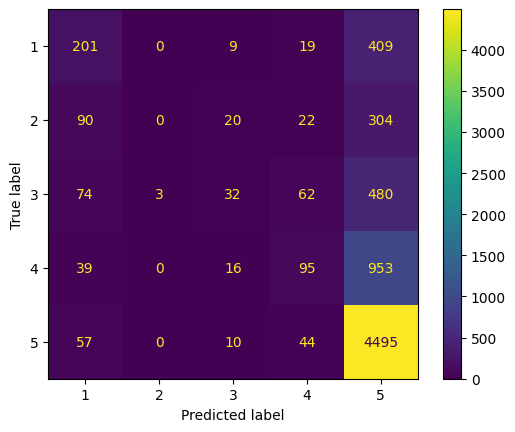

In [57]:
from sklearn.svm import LinearSVC
model_svm1 = LinearSVC(C=1.0, random_state=42)
model_svm1.fit(X_train, y_train)
y_pred_svm1 = model_svm1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm1))
ConfusionMatrixDisplay.from_estimator(model_svm1, X_test, y_test)
plt.show()

Accuracy: 0.6520043045466775


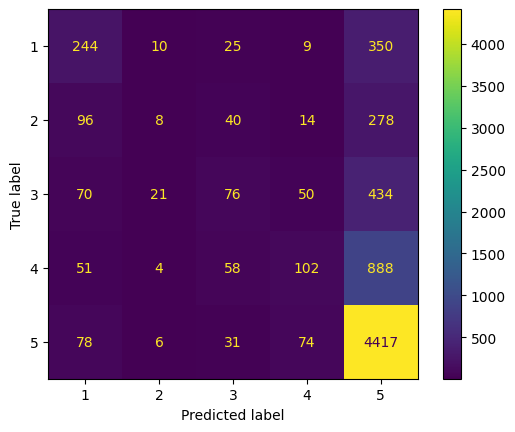

In [58]:
from sklearn.linear_model import LogisticRegression
model_lr1 = LogisticRegression()
model_lr1.fit(X_train, y_train)
y_pred1 =model_lr1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))
ConfusionMatrixDisplay.from_estimator(model_lr1, X_test, y_test)
plt.show()

In [60]:
from tqdm import tqdm
from bs4 import BeautifulSoup
import re


def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def decontracted(phrase):

    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)


    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


preprocessed_summaries = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(sentance.strip())

print("\nFirst 10 preprocessed summaries:")
for i in range(10):
    print(preprocessed_summaries[i])

100%|██████████| 24779/24779 [00:01<00:00, 14910.16it/s]


First 10 preprocessed summaries:
made china
dog lover delites
flies begone
thirty bucks
great product
wow make islickers
best herbal tea digestion
best cleansing tea ever
good effective product
premium quality dog food


In [62]:
preprocessed_summaries

['made china',
 'dog lover delites',
 'flies begone',
 'thirty bucks',
 'great product',
 'wow make islickers',
 'best herbal tea digestion',
 'best cleansing tea ever',
 'good effective product',
 'premium quality dog food',
 'good stuff',
 'cats love',
 'great beef look',
 'family favorite looks like steak',
 'great food',
 '',
 'not favorite house',
 'four cats love',
 'cats love food',
 'stuff bad',
 'not best',
 'great food',
 'great food cats',
 'needs improved',
 'awesome food',
 'cat favorite',
 'great product',
 'finicky eater favorite food',
 'not different regular friskies',
 'pleasing finicky cats',
 'cat breath smells like cat food',
 'mmmmmmmeeeeeeeeeeooooooooooowwwwwww',
 'one great big huge high five cat',
 'canidae felidae',
 'best money',
 'schnauzers love',
 'feeding boarding kennel excellent investment',
 'always great',
 'good healthy dog food',
 'changed formula cant change rating one star',
 'loving new dog food',
 'fantastic',
 'warning',
 'excellent product',
 

Accuracy: 0.4835889157923056


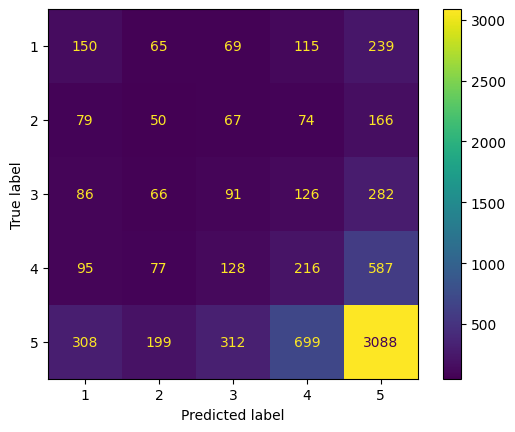

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = model_dt.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
ConfusionMatrixDisplay.from_estimator(model_dt, X_test, y_test)
plt.show()

Test Accuracy: 0.6520043045466775
Train Accuracy: 0.6490631305851831


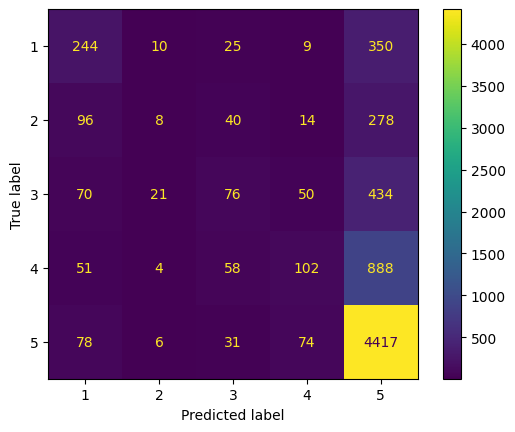

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

y_pred_lr_test = model_lr.predict(X_test)
y_pred_lr_train = model_lr.predict(X_train)

print("Test Accuracy:", accuracy_score(y_test, y_pred_lr_test))

print("Train Accuracy:", accuracy_score(y_train, y_pred_lr_train))

ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test)
plt.show()

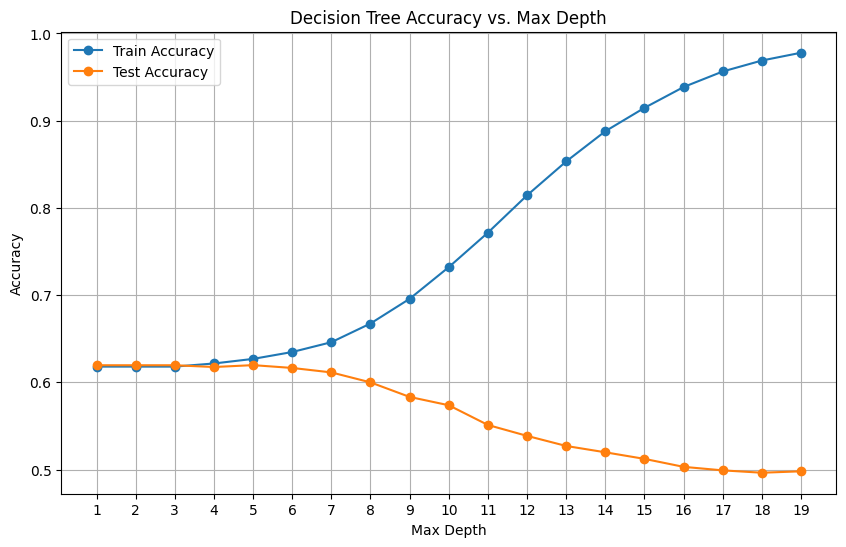

In [70]:

train_accuracies = []
test_accuracies = []
depths = range(1, 20)  # Test depths from 1 to 20

for depth in depths:
    model_dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_dt.fit(X_train, y_train)

    y_pred_train = model_dt.predict(X_train)
    train_acc = accuracy_score(y_train, y_pred_train)
    train_accuracies.append(train_acc)

    y_pred_test = model_dt.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_accuracies.append(test_acc)

plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(depths, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Decision Tree Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()